# **WasteDetector**
In this project, we will train a NN for classification of Drinking Waste that a beach-cleaning robot will use to detect waste and collect it.

## **Data Analysis**

### **Import libraries**
In this section we will import all the required libraries for this project

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# ignore irrelevant warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### **Loadning the Dataset**
Now we'll load the Dataset, for this project we will use the ***Drinking Waste Classification*** dataset from Kaggle.

### Load Kaggle Dataset without downloading it

#### Get Kaggle API Token

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marianasosa","key":"7059a18951fe23ba4a738979e5ae60db"}'}

In [ ]:
# Make a directory named kaggle and copy the kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

#### Get Kaggle Dataset API Command

In [ ]:
# !your dataset api command
!kaggle datasets download -d arkadiyhacks/drinking-waste-classification

 99% 1.48G/1.50G [00:09<00:00, 177MB/s]
100% 1.50G/1.50G [00:09<00:00, 161MB/s]


In [ ]:
from zipfile import ZipFile
file_name = 'drinking-waste-classification.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
for dirname, _, filenames in os.walk('Images_of_Waste'):
    print(dirname)

Images_of_Waste
Images_of_Waste/rawimgs
Images_of_Waste/rawimgs/Glass
Images_of_Waste/rawimgs/HDPEM
Images_of_Waste/rawimgs/AluCan
Images_of_Waste/rawimgs/PET
Images_of_Waste/YOLO_imgs


In this case, we'll only use the `rawimgs` directory since the YOLO_imgs is designed for the YOLO framework and we want to design our own classifier.

In [ ]:
# TODO: Delete the YOLO_imgs folder
for dirname, _, filenames in os.walk('Images_of_Waste/YOLO_imgs'):
    for file in filenames:
        # TODO: delete files
        print(file)

In [ ]:
# rawimgs folder
for dirname, _, filenames in os.walk('Images_of_Waste/rawimgs'):
    print(dirname)
    # for file in filenames:
    #   print(file)

Images_of_Waste/rawimgs
Images_of_Waste/rawimgs/Glass
Images_of_Waste/rawimgs/HDPEM
Images_of_Waste/rawimgs/AluCan
Images_of_Waste/rawimgs/PET


The dataset has the following directory structure:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>rawimgs</b>
|__ <b>AluCan</b>
    |______ AluCan1,000.jpg
    |______ AluCan1,001.jpg
    |______ AluCan1,002.jpg
    ....
|__ <b>Glass</b>
    |______ Glass1,000.jpg
    |______ Glass1,001.jpg
    |______ Glass1,002.jpg
    ....
|__ <b>HDPEM</b>
    |______ HDPEM1,000.jpg
    |______ HDPEM1,001.jpg
    |______ HDPEM1,002.jpg
    ....
|__ <b>PET</b>
    |______ PET1,000.jpg
    |______ PET1,001.jpg
    |______ PET1,002.jpg
    ....
</pre>

We can see that all the data is collected in the `rawimgs` folder, which has 4 folders containing images of Cans, Glass, HDPEM and PET bottles. We need to separate this data in 3 sets: `train`, `validation` and `test` sets, with a rate of 0.8%, 0.1% and 0.1% of the data respectively.<br>

### **Data Preparation**
This dataset only contains the images in folders, it not contains labels itself. Therefore, we need to add them in order to use Supervised Learning techniques.

For this purpose, we will use the `**split-folders**` package.<br>
This package splits folders with files (e.g. images) into train, validation and test (dataset) folders. (Check the documentation https://pypi.org/project/split-folders/).<br>
The input folder should have the following format:
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>input/</b>
|__ <b>AluCan/</b>
    |______ alucan1.jpg
    |______ alucan2.jpg
    ...
|__ <b>Glass/</b>
    |______ glass1.jpg
    ...
|__ <b>...</b>
</pre>

And returns this:
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>output/</b>
|__<b>train/</b>
|___ AluCan/
    |______ alucan1.jpg
    |______ alucan2.jpg
    ...
|___ Glass/
    |______ glass1.jpg
    ...
|___ <b>...</b>
|__<b>val/</b>
|___ AluCan/
    |______ alucan8.jpg
    |______ alucan10.jpg
    ...
|___ Glass/
    |______ glass11.jpg
    ...
|___ <b>...</b>
|__<b>test/</b>
|___ AluCan/
    |______ alucan32.jpg
    |______ alucan98.jpg
    ...
|___ Glass/
    |______ glass78.jpg
    ...
|___ <b>...</b>
</pre>

In [ ]:
# Installing package
%pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
# Split with a ratio

# the seed parameter makes splits reproducible. The default value is 1337.
# for the moment, we'll leave it like that
# group_prefix is not important for the moment (Check the documentation:
# https://pypi.org/project/split-folders/)
# move=True moves the files to the output folder
# move=False makes a copy of the files to the output folder
# in this case we'll move the files to save memory
splitfolders.ratio(
    "Images_of_Waste/rawimgs", output="rawimgs_splited",
    ratio=(0.8, 0.1, 0.1),
    move=True
)

Copying files: 4828 files [00:00, 7726.20 files/s]


In [ ]:
for dirname, _, filenames in os.walk('rawimgs_splited'):
    print(dirname)

rawimgs_splited
rawimgs_splited/train
rawimgs_splited/train/Glass
rawimgs_splited/train/HDPEM
rawimgs_splited/train/AluCan
rawimgs_splited/train/PET
rawimgs_splited/test
rawimgs_splited/test/Glass
rawimgs_splited/test/HDPEM
rawimgs_splited/test/AluCan
rawimgs_splited/test/PET
rawimgs_splited/val
rawimgs_splited/val/Glass
rawimgs_splited/val/HDPEM
rawimgs_splited/val/AluCan
rawimgs_splited/val/PET


Now that we have all the images separated in train, val, and test sets. We will assign the paths of each folder to some variables.

In [ ]:
base_dir = 'rawimgs_splited'
classes = ['AluCan', 'Glass', 'HDPEM', 'PET']

train_dirs = {
    'train_dir': os.path.join(base_dir, 'train')
}
val_dirs = {
    'val_dir': os.path.join(base_dir, 'val')
}

test_dirs = {
    'test_dir': os.path.join(base_dir, 'test')
}

for class_name in classes:
    train_dirs[class_name] = os.path.join(train_dirs['train_dir'], class_name)
    val_dirs[class_name] = os.path.join(val_dirs['val_dir'], class_name)
    test_dirs[class_name] = os.path.join(test_dirs['test_dir'], class_name)

### **Exploring the Data**
Check how many images are in this dataset

In [ ]:
total = 0
for class_name in classes:
    num_tr = len(os.listdir(train_dirs[class_name]))
    num_vl = len(os.listdir(val_dirs[class_name]))
    num_ts = len(os.listdir(test_dirs[class_name]))
    total = num_tr + num_vl + num_ts

    print(f'\nNumber of {class_name} images in the dataset: {total}')
    print('\u2022 {:,} training set'.format(num_tr))
    print('\u2022 {:,} validation set'.format(num_vl))
    print('\u2022 {:,} testing set'.format(num_ts))


Number of AluCan images in the dataset: 1060
• 848 training set
• 106 validation set
• 106 testing set

Number of Glass images in the dataset: 1232
• 985 training set
• 123 validation set
• 124 testing set

Number of HDPEM images in the dataset: 1028
• 822 training set
• 102 validation set
• 104 testing set

Number of PET images in the dataset: 1508
• 1,206 training set
• 150 validation set
• 152 testing set


### **Create Pipeline**
For this task, we need to use the `ImageDataGenerator` class to apply some transformations to the images.

In [ ]:
# By default the .flow_from_directory() method uses a batch
# size of 32 and image shape of (256, 256)
BATCH_SIZE = 64
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)

Found 3856 images belonging to 4 classes.


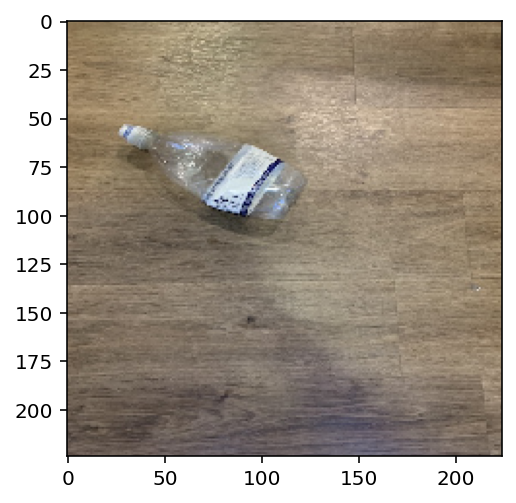

<class 'keras.preprocessing.image.DirectoryIterator'>


In [ ]:
image_gen = ImageDataGenerator(rescale=1./255) # to normalize
img = image_gen.flow_from_directory(directory=train_dirs['train_dir'],
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        target_size=IMG_SHAPE,
                                        class_mode='binary')
plt.imshow(img[0][0][0])
plt.show()
print(type(img))

### **Data Augmentation**
When training a Neural Network it is useful to create randomness in the input data, so the network can classify correctly an image even if it's rotated, fliped, scaled, etc. This transformations can be done with the `ImageDataGenerator` class.

In [ ]:
# Function for plotting the images in a row from 1 to 5
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

#### **Flipping Images Horizontally**
Random flip to images in our training set.

horizontal_flip = True

Found 3856 images belonging to 4 classes.


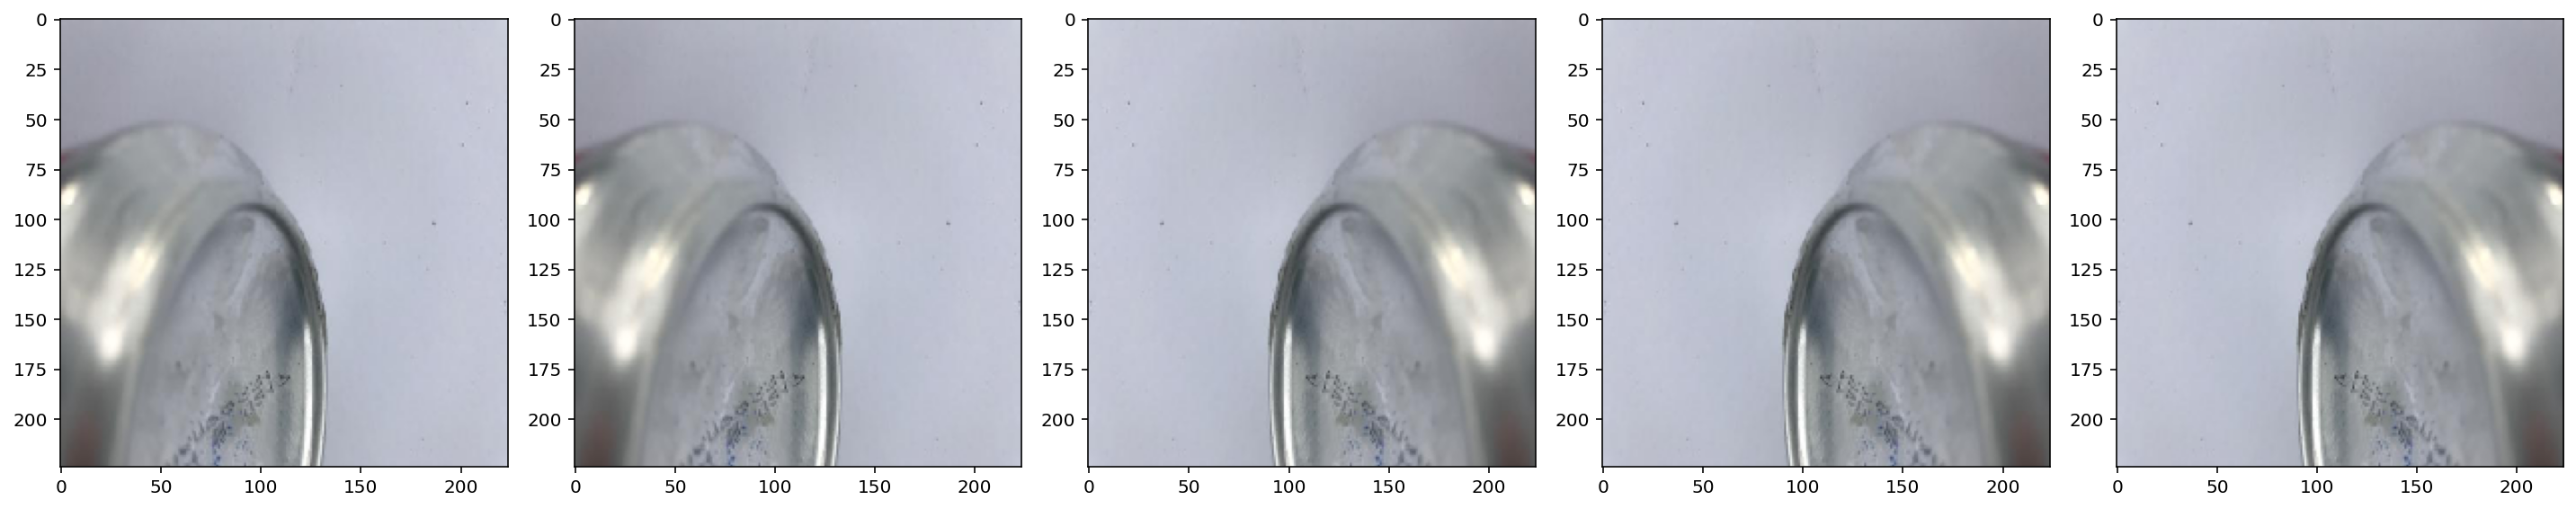

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(directory=train_dirs['train_dir'],
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               target_size=IMG_SHAPE,
                                               class_mode='binary')
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

#### **Rotating the image**
Random rotation to image in our training set.

rotation_range = angle

Found 3856 images belonging to 4 classes.


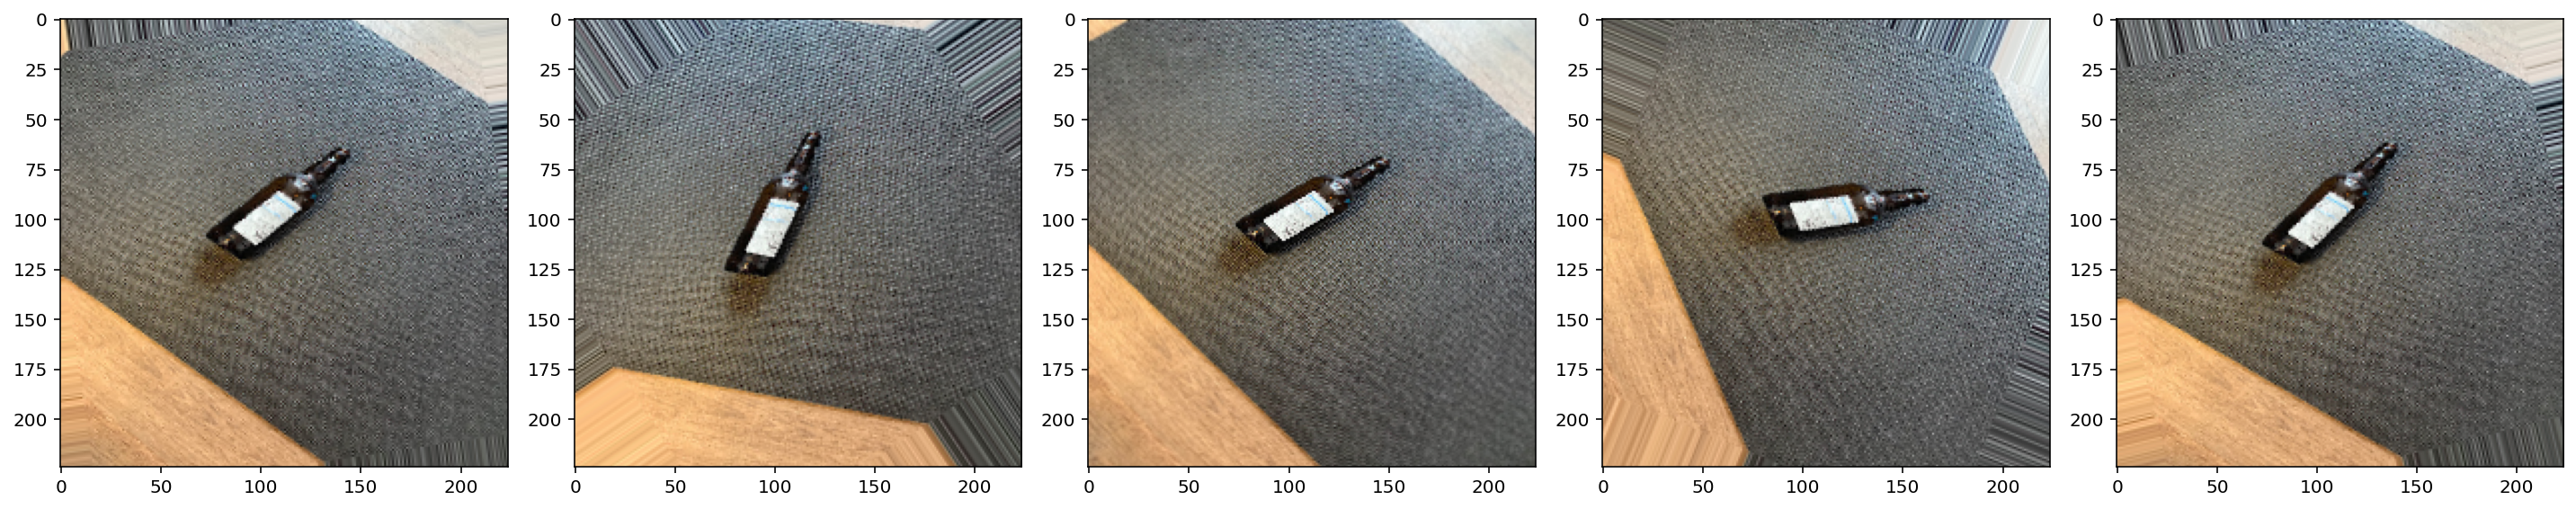

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(directory=train_dirs['train_dir'],
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               target_size=IMG_SHAPE,
                                               class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

#### **Applying Zoom**
Random zooming to image of our training set.

zoom_range = range

Found 3856 images belonging to 4 classes.


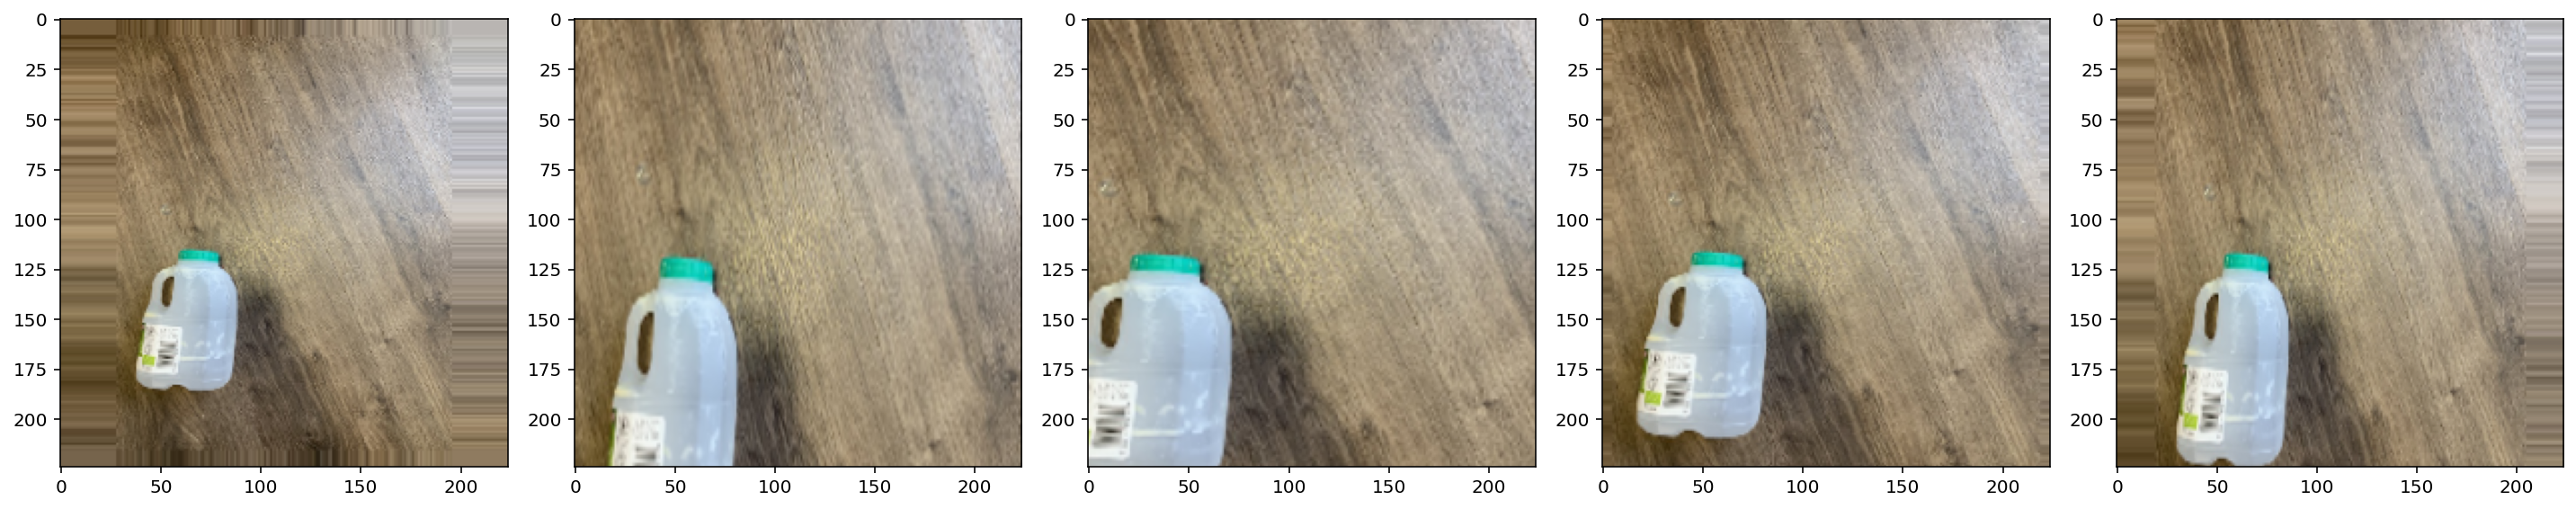

In [ ]:
image_gen =ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(directory=train_dirs['train_dir'],
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               target_size=IMG_SHAPE,
                                               class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

#### **All augmentations together**

In [ ]:
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(directory=train_dirs['train_dir'],
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=IMG_SHAPE,
                                                     class_mode='binary')

Found 3856 images belonging to 4 classes.


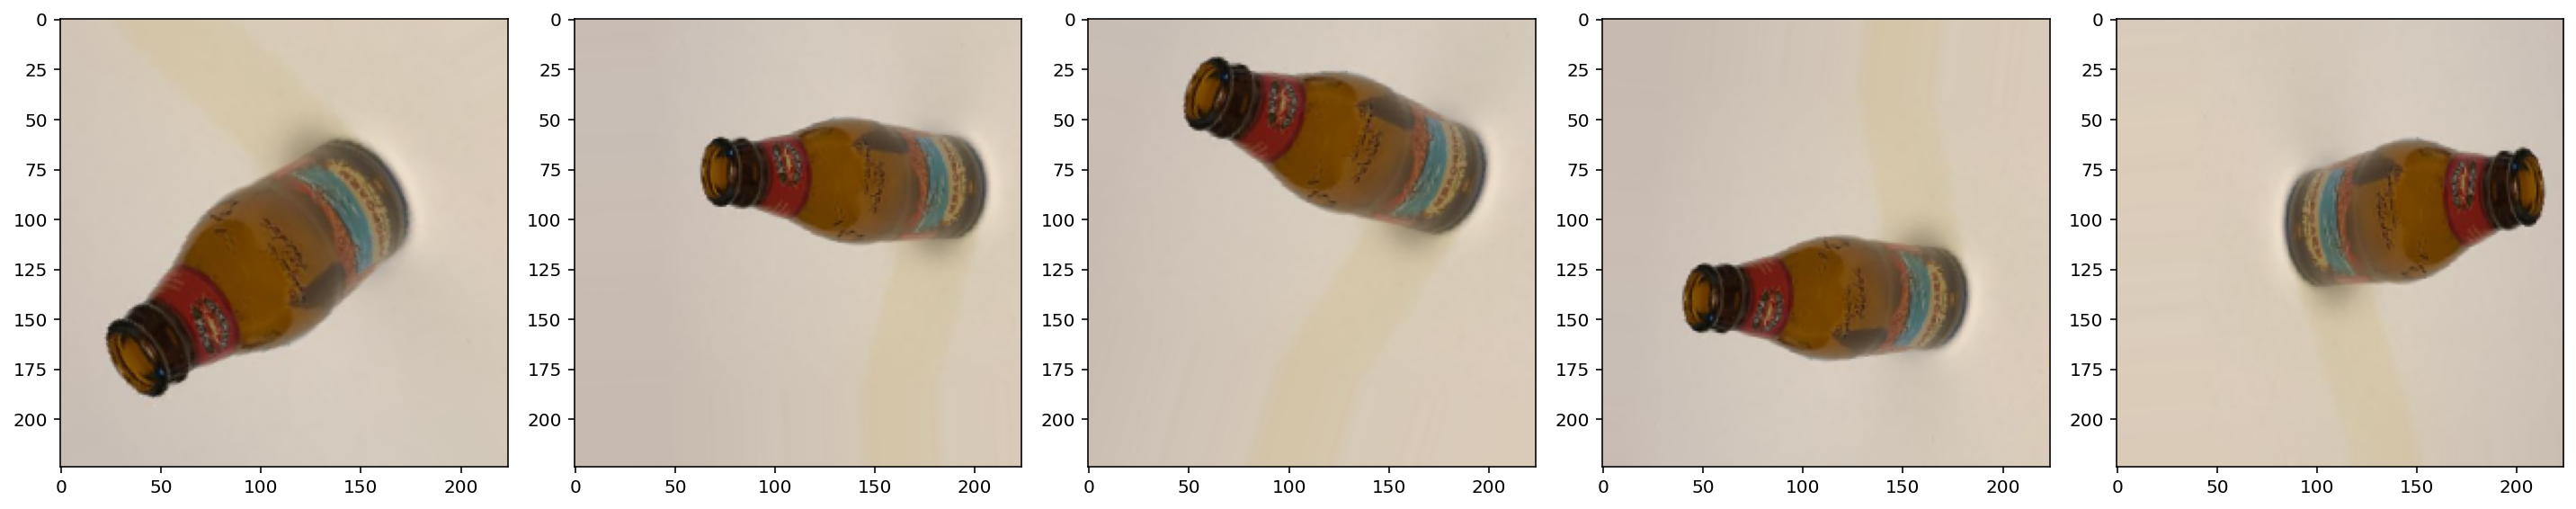

In [ ]:
# Just to check 5 images after augmentation
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

In [ ]:
# Augmentation for validation and testing sets.
# For this sets we don't need to apply all the augmentations
# that we applied for the training set, but a rescale is
# necessary so we can pass the images to the model.
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(directory=val_dirs['val_dir'],
                                                 batch_size=BATCH_SIZE,
                                                 target_size=IMG_SHAPE,
                                                 class_mode='binary')

test_data_gen = image_gen_val.flow_from_directory(directory=test_dirs['test_dir'],
                                                  batch_size=BATCH_SIZE,
                                                  target_size=IMG_SHAPE,
                                                  class_mode='binary')

Found 479 images belonging to 4 classes.
Found 485 images belonging to 4 classes.


## **AI Model**

### **Import MobileNet Classifier**
Now that we analized our data and made some augmentations, we can build and train our BottlesClassifier, for this task we will use the MobileNet pre-trained model from TensorFlow Hub to get the image features.

Our pre-trained model will be responsible for extracting the features of our images, we will therefore call this part of our model the feature_extractor.

In [ ]:
# Importing MobileNet
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
# we only download the pre-trained model without the final classification
# layer, so we can use it with our data
# MobileNet was trained with images of shape (224, 224, 3)
feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [ ]:
# we need to freeze the weights and biases of the pre-trained model
# to avoid modifying them during training
feature_extractor.trainable = False

### Build the Model
We will create a `tf.keras` Sequential model with our `feature_extractor` and a new classification layer. Since our dataset has 4 classes we create an output layer with 4 units.

In [ ]:
my_model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Compile the model
my_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=7)
# Save the best model
save_best_model = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                                     monitor='val_loss',
                                                     save_best_only=True)

In [ ]:
# Train model
EPOCHS = 15
history = my_model.fit(train_data_gen,
                       epochs=EPOCHS,
                       validation_data=val_data_gen)

Epoch 1/15
61/61 [==============================] - 198s 3s/step - loss: 0.8230 - accuracy: 0.6699 - val_loss: 0.4322 - val_accuracy: 0.8539
Epoch 2/15
61/61 [==============================] - 189s 3s/step - loss: 0.4325 - accuracy: 0.8509 - val_loss: 0.3108 - val_accuracy: 0.8914
Epoch 3/15
61/61 [==============================] - 194s 3s/step - loss: 0.3418 - accuracy: 0.8843 - val_loss: 0.2611 - val_accuracy: 0.9144
Epoch 4/15
61/61 [==============================] - 191s 3s/step - loss: 0.2879 - accuracy: 0.9059 - val_loss: 0.2552 - val_accuracy: 0.9081
Epoch 5/15
61/61 [==============================] - 188s 3s/step - loss: 0.2588 - accuracy: 0.9168 - val_loss: 0.2316 - val_accuracy: 0.9144
Epoch 6/15
61/61 [==============================] - 190s 3s/step - loss: 0.2360 - accuracy: 0.9232 - val_loss: 0.2110 - val_accuracy: 0.9248
Epoch 7/15
61/61 [==============================] - 193s 3s/step - loss: 0.2249 - accuracy: 0.9274 - val_loss: 0.2373 - val_accuracy: 0.9123
Epoch 8/15
61

In [ ]:
# Get the keys of the history dictionary
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


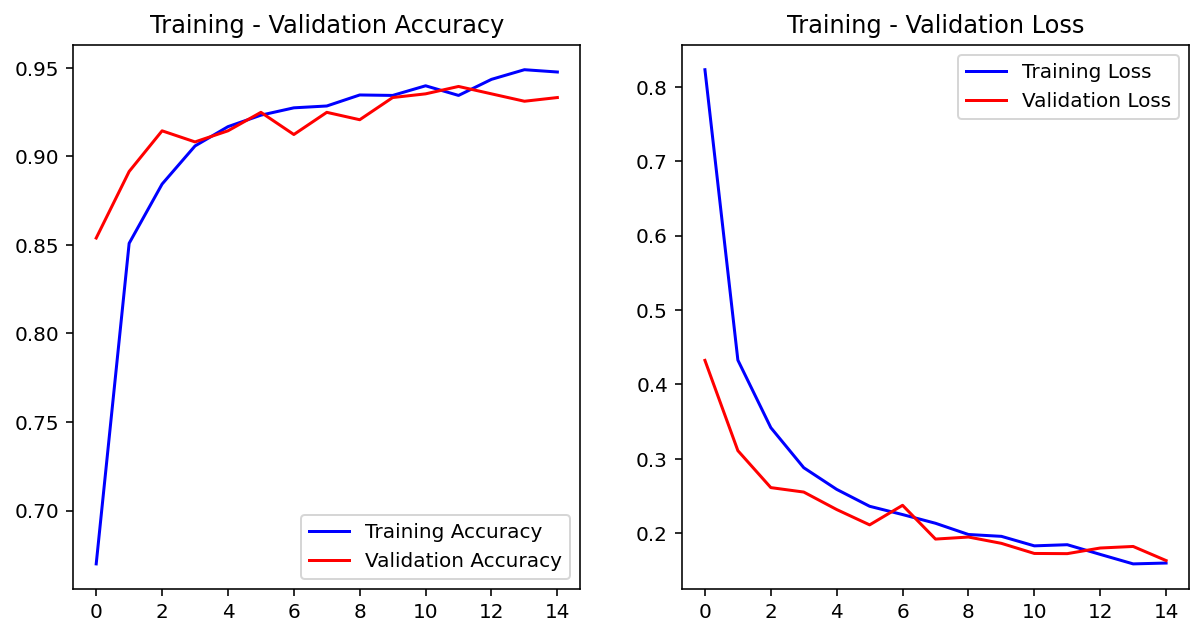

In [ ]:
# TODO: plot the loss and accuracy values achieved during training
# for the training and validation set
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, 'b', label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, 'r', label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training - Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, 'b', label = 'Training Loss')
plt.plot(epochs_range, validation_loss, 'r', label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training - Validation Loss')
plt.show()

### **Testing the Network**

In [ ]:
loss, accuracy = my_model.evaluate(test_data_gen)
print('Loss and Accuracy on Testing Data')
print('Loss: {}'.format(loss))
print('Accuracy: {}'.format(accuracy))

8/8 [==============================] - 18s 2s/step - loss: 0.1477 - accuracy: 0.9505
Loss and Accuracy on Testing Data
Loss: 0.14770400524139404
Accuracy: 0.9505154490470886


In [ ]:
# save the model
path = './waste_detector_model.h5'
my_model.save(path)